<a href="https://colab.research.google.com/github/MuktaUbale/game-of-life/blob/main/Life_in_NumPy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NumPy Project: Create a Life implementation

In [ ]:
import numpy as np
from IPython.display import clear_output
import time
import matplotlib.pyplot as plt
%matplotlib inline

## Introduction
---
From Wikipedia:
> The Game of Life, also known simply as Life, is a cellular automaton devised by the British mathematician John Horton Conway in 1970. It is a zero-player game, meaning that its evolution is determined by its initial state, requiring no further input. One interacts with the Game of Life by creating an initial configuration and observing how it evolves.

> The universe of the Game of Life is an infinite, two-dimensional orthogonal grid of square cells, each of which is in one of two possible states, live or dead, (or populated and unpopulated, respectively). **Every cell interacts with its eight neighbours, which are the cells that are horizontally, vertically, or diagonally adjacent.**

After given a starting state (aka seed), cells will live or die in each generation/iteration based on the rules here (also  from Wikipedia):

### Rules of Life:
1. If a living cell has fewer than 2 living neighbors, it dies (loneliness)

2. If a living cell has 2-3 living neighbors, it continues to live

3. If a living cell has more than 3 living neighbors, it dies (overpopulation)

4. If a dead cell has exactly 3 living neighbors, it becomes alive (reproduction).

### Example implementation:
Here's a site that you can use to see how it works: https://conwaylife.com/.

### Condensed rules:
For coding though, we'll condense these 4 rules into 3:

1. Any living cell with 2 or 3 living neighbors live.
2. Any dead cell with exactly 3 living neighbors comes to (new) life.
3. All other cells die or stay dead.

## The "living space"

By now, you might already have an idea of how to implement this game in a traditionally Pythonic way, with for loops and lists. However, we will use NumPy arrays instead.  It will be faster and much more elegant with NumPy.

In this case, 0 will represent a dead cell while 1 will represent a living cell. And instead of an infinite universe, our cells' "living space" will be limited to just the size of a NumPy array, excluding a border of size 1. (Having this extra border will useful for calculations.)

For instance, in the following NumPy array,
```
Z=np.array([[0, 0],
            [0, 0]])
```
there is no living space (because there's a border of size 1; it's all border).

Another example: in the following array,
```
Z=np.array([[0, 0, 0, 0, 0],
           [0, 1, 1, 0, 0],
           [0, 0, 0, 0, 0],
           [0, 1, 0, 1, 0],
           [0, 0, 0, 0, 0]])
```
there are 9 cells in the living space (4 of which are "alive"), out of 25 cells total.

### Warm-up exercise: slicing

Use slicing to set the living space of the `Z` array to all ones.

In [ ]:
Z=np.array([[0, 0, 0, 0, 0],
           [0, 1, 1, 0, 0],
           [0, 0, 0, 0, 0],
           [0, 1, 0, 1, 0],
           [0, 0, 0, 0, 0]])

In [ ]:
Z[1:-1,1:-1] = np.ones(Z[1:-1,1:-1].shape)
# Better: Z[1:-1,1:-1] = 1
Z

array([[0, 0, 0, 0, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 1, 1, 1, 0],
       [0, 0, 0, 0, 0]])

### Warm-up exercise: Boolean masking
Exercise: Suppose you have a Boolean array, `bool_n`, And suppose you have an array of zeroes, `new_arr` with the same shape.  Set all of the corresponding entries in new_arr to 0 and 1 depending on the False and True entries in bool_n.

In [ ]:
bool_n = np.array([[False, False, False, False],
                   [False, False, False, False],
                   [False,  True,  True,  True],
                   [False, False, False, False]])
new_arr = np.zeros(bool_n.shape) # Create a blank array

In [ ]:
new_arr[bool_n] = 1
new_arr = new_arr.astype(int)
new_arr

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 1, 1, 1],
       [0, 0, 0, 0]])

## Graphical representation: the show1 function
For easier visualization, you can use the function `show1` below to visualize the above arrays.

You don't need to understand this function, just know how to use it.

In [ ]:
def show1(Z): # graphically display the "living space" when passed an array
    size = np.array(Z.shape)
    dpi = .001
    figsize= size[1]/float(dpi)*10,size[0]/float(dpi)*10
    fig = plt.figure(figsize=figsize, dpi=dpi, facecolor="green")
    fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=False)
    plt.imshow(Z,interpolation='nearest', cmap=plt.cm.gray_r)
    plt.xticks([]), plt.yticks([])
    plt.show()

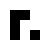

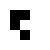

In [ ]:
Z=np.array([[0, 0, 0, 0, 0],
           [0, 1, 1, 0, 0],
           [0, 1, 0, 0, 0],
           [0, 1, 0, 1, 0],
           [0, 0, 0, 0, 0]])

Z_2= np.array([[0, 0, 0, 0, 0],
               [0, 1, 1, 0, 0],
               [0, 1, 0, 0, 0],
               [0, 0, 1, 0, 0],
               [0, 0, 0, 0, 0]])
show1(Z)
show1(Z_2)

# Part I: Writing the iterate_one_generation function
We want to write a function `iterate_one_generation(living_space)`, which will accept a NumPy array `living_space` and return its "next stage": an array of the same shape, generated based on the rules of Life.

For example, given the following array:
```
Z=np.array([[0, 0, 0, 0, 0],
           [0, 1, 1, 0, 0],
           [0, 1, 0, 0, 0],
           [0, 1, 0, 1, 0],
           [0, 0, 0, 0, 0]])
```

`iterate_one_generation(Z)` should return this array:
```
Z_2 = np.array([[0, 0, 0, 0, 0],
                [0, 1, 1, 0, 0],
                [0, 1, 0, 0, 0],
                [0, 0, 1, 0, 0],
                [0, 0, 0, 0, 0]])
```

**Constraint: In writing this function you will NOT be allowed to use any loops.**

## Step I: The number-of-neighbors array

To code the Game of Life, it will be necessary to create a "number-of-neighbors array" - that is, an array whose entries signify the number of neighbors that each position has.  The following exercise will be helpful.  

### Warm-up exercise: More slicing

Slice the array `tmp` so that we have everything except the bottom two rows and the two columns on the right.
```
tmp = np.array([[0,0,0,0,0,0],
                [0,0,0,1,0,0],
                [0,1,0,1,0,0],
                [0,0,1,1,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0]])
```

You should end up with something like this
```
array([[0, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 1, 0, 1],
       [0, 0, 1, 1]])
```

In [ ]:
tmp = np.array([[0,0,0,0,0,0],
                [0,0,0,1,0,0],
                [0,1,0,1,0,0],
                [0,0,1,1,0,0],
                [0,0,0,0,0,0],
                [0,0,0,0,0,0]])

In [ ]:
# Slice the tmp array so that we have everything except the bottom 2 rows and right 2 columns.
# your code here

tmp[:-2,:-2]

### Creating the number-of-neighbors array using slicing and adding

Consider our tmp array above (where, recall, the zeroes around the edge are just a boundary - i.e., not part of the actual game).  Its "number of neighbors"-array looks like this:
```
array([[0, 0, 0, 0, 0, 0],
       [0, 1, 3, 1, 2, 0],
       [0, 1, 5, 3, 3, 0],
       [0, 2, 3, 2, 2, 0],
       [0, 1, 2, 2, 1, 0],
       [0, 0, 0, 0, 0, 0]])
```

(The clever part:) **Use slicing and arithmetic** to generate the number of neighbors array for the 'Z' array (aka the tmp array) yourself below.  Hint: it will be the sum of some subarrays....

In [ ]:
Z = np.array([[0,0,0,0,0,0],
              [0,0,0,1,0,0],
              [0,1,0,1,0,0],
              [0,0,1,1,0,0],
              [0,0,0,0,0,0],
              [0,0,0,0,0,0]])

# Generate a number-of-neighbors array for Z
# your code here

## Step II: Creating the Birth/Survival array

Once you can count neighbors, you need to figure out how to apply the rules of life (which depend on the number of neighbors...

### Exercise: Looking for entries with three neighbors

Given the NumPy array `N` below,
```
N = np.array([ [1, 3, 1, 2],
               [1, 5, 3, 3],
               [2, 3, 2, 2],
               [1, 2, 2, 1]  ])
```
make a new NumPy array `new_N` where `new_N[i,j]` is `True` if `N[i,j]` is 3 and `new_N[i,j]` is `False` otherwise.

Your result should look like this:
```
array([[False,  True, False, False],
       [False, False,  True,  True],
       [False,  True, False, False],
       [False, False, False, False]])
```

In [ ]:
N = np.array([ [1, 3, 1, 2],
               [1, 5, 3, 3],
               [2, 3, 2, 2],
               [1, 2, 2, 1]])

# make a new NumPy `new_N` where `new_N[i,j]` is True if `N[i,j]` is 3
# and `new_N[i,j]` is False otherwise
# your code here

### Exercises: Birth and Survival arrays

Exercises:

1. Can you figure out which cells in the living space are dead and have exactly 3 neighbors (i.e., will be born in the next iteration)?
2. How about which cells (again in the living space) are alive and have between 2-3 neighbors (i.e., will survive)?

(Hint: use boolean operators and slicing)

---

Try it out with array `Z` below.

In [ ]:
# try it!
Z = np.array([[0,0,0,0,0,0],
              [0,0,0,1,0,0],
              [0,1,0,1,0,0],
              [0,0,1,1,1,0],
              [0,0,0,0,0,0],
              [0,0,0,0,0,0]])

In [ ]:
# birth array
# your code here

In [ ]:
# survival array
# your code here

You should have ended up with a birth array like this:
```
array([[False,  True, False, False],
       [False, False, False, False],
       [False, False, False, False],
       [False, False,  True, False]])
```

and a survival array like this:
```
array([[False, False, False, False],
       [False, False, False, False],
       [False,  True,  True,  True],
       [False, False, False, False]])
```

## Step III: Writing the function

At this point, you have all the pieces necessary to build the function.
For reference, here's a quick review of the game:

> 0 will represent a dead cell while 1 will represent a living cell. Instead of an infinite universe, our cells' living space will be limited to just the size of a NumPy array without including a border of size 1. And here are the rules:
>
> 1. Any living cell with 2 or 3 living neighbors live
> 2. Any dead cell with exactly 3 living neighbors live.
> 3. All other cells die or stay dead :(

Remember, **NO LOOPS** yet.

In [ ]:
def iterate_one_generation(space):
    # count the neighbors


    # who will survive?



    # who will be reproduced?

    # apply rules
    pass


# Part II: Writing the Life program

## Testing your function
**Lifting the constraint:** Okay, now you're allowed to use loops.

Let's test your function.  Here is an initial state:

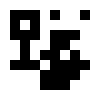

In [ ]:
living_space = np.array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 1., 0., 0., 1., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 1., 1., 1., 0., 0.],
       [0., 0., 1., 0., 0., 1., 1., 0., 0., 0.],
       [0., 0., 1., 0., 1., 1., 0., 1., 0., 0.],
       [0., 1., 1., 1., 0., 1., 1., 1., 1., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
show1(living_space)

Run the above state through 100 iterations of your function: you should end up with the following.
```
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
```
The image should look kind of like a flower and square after 100 runs (it technically stabilizes in less 100 runs though).


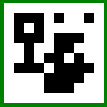

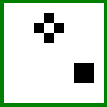

In [ ]:
# Iterating through 100 generations:
for _ in range(100):
    iterate_one_generation(living_space) # you may have to adjust this line depending on what your function does

show1(living_space)

## Better graphical representation: show

The new `show` function below will accept two more optional parameters: the animation will pause for `sleepT` seconds after showing an image. A `scale` will help determine our image size in relation to the NumPy array size passed in. A larger scale number indicates a larger image while a smaller scale should give a smaller image.

In [ ]:
def show(Z, sleepT=0, scale=1):
    clear_output(wait=True)
    size = np.array(Z.shape)
    dpi = 75.0
    figsize= size[1]/float(dpi)*scale,size[0]/float(dpi)*scale
    fig = plt.figure(figsize=figsize, dpi=dpi, facecolor="green")
    fig.add_axes([0.0, 0.0, 1.0, 1.0], frameon=False)
    plt.imshow(Z,interpolation='nearest', cmap=plt.cm.gray_r)
    plt.xticks([]), plt.yticks([])
    plt.show()
    time.sleep(sleepT)

Now, try running your function on a random `seed` or `living_space`.
The function `np.random.randint` will be useful (https://NumPy.org/doc/stable/reference/random/generated/NumPy.random.randint.html).

Make sure to change all variables that have been initialized to `-1`; you'll have problems if you don't.

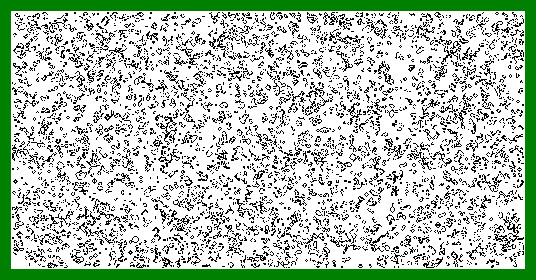

In [ ]:
# h, w will represent the height, width of your cells' living space
# change the numbers as you please
h = 256
w = 512

# create a random seed (NumPy) with (h,w) shape
seed = np.random.randint(0,2, (h,w))
Z = np.zeros((h+2, w+2)) # creating an array of zeroes of the right size
Z[1:-1, 1:-1] = seed # copying the seed into the living_space of Z

# change scale and sleepT to what you want
sleep_time = -1
scale =

show(Z, sleepT=sleep_time, scale=scale)

# feel free to change the # of generations passed after testing
for _ in range(10):
    iterate_one_generation(Z) # you may have to adjust this line depending on what your function does
    show(Z, sleepT=sleep_time, scale=scale)

---
If you're done early, here are a few...

## Challenges

1. What patterns do you notice between iterations?
2. Try to find patterns that use a minimal number of live cells but take a maximal number of generations to stabilize.  What kind of common qualities do they have?
3. Check out patterns that often occur at Wiki (look it up!). Can you reproduce them together from one seed? How long do they last before one of them disappears or can the patterns coexist together?
3. Try experimenting with the rules! Why did Conway choose these rules?